In [12]:
CLASSES = ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']

In [23]:
from torchvision import datasets, transforms
from torch.utils.data import random_split

# Define the data directory
data_dir = './kaggle/input/UCMerced_LandUse/Images'

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

# Load the full dataset
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Calculate sizes for train, validation, and test sets
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

print(f"Total images: {total_size}")
print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")
print(f"Testing images: {len(test_dataset)}")

# Verify class names
class_names = full_dataset.classes
assert set(class_names) == set(CLASSES), "Mismatch between expected and actual class names"
print("Class names verified successfully")


Total images: 2100
Training images: 1470
Validation images: 315
Testing images: 315
Class names verified successfully


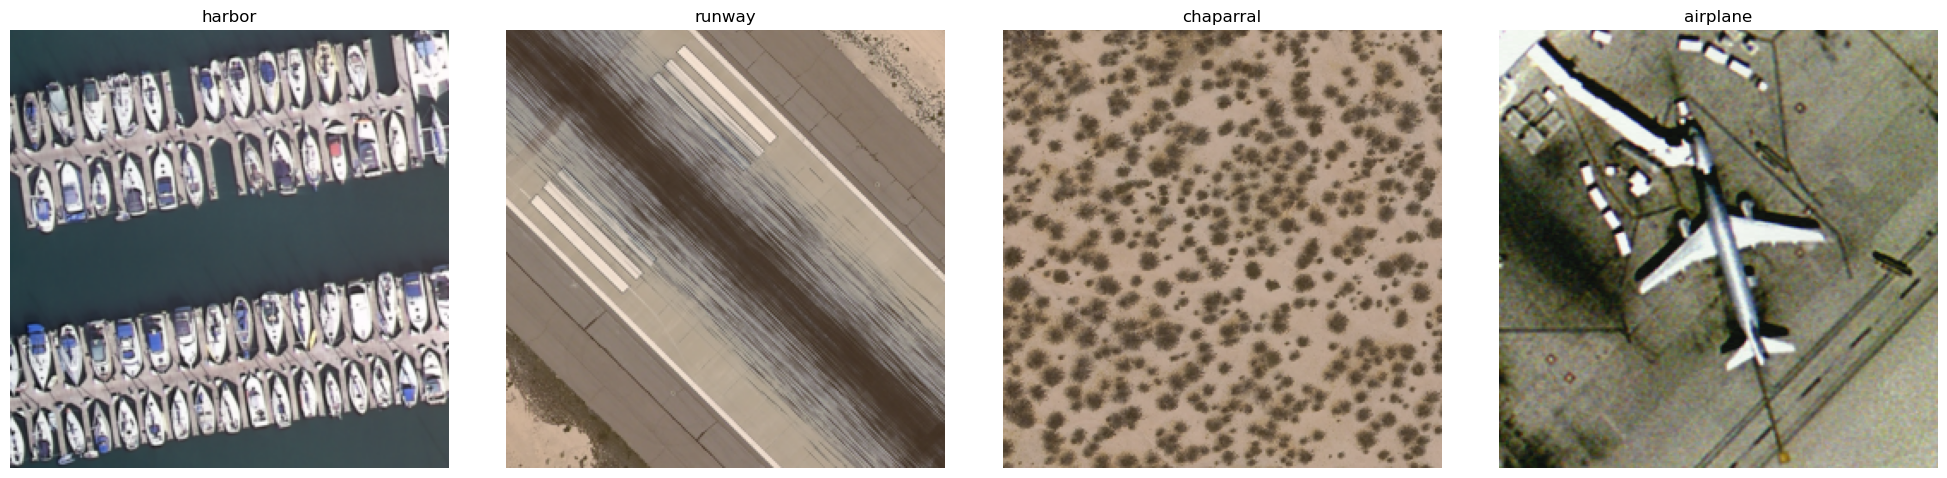

In [16]:
import matplotlib.pyplot as plt
import random

def imshow(img, title=None):
    img = img.permute(1, 2, 0)  # rearrange dimensions for plotting
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# Set up the plot
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
plt.tight_layout()

# Get 4 random indices
random_indices = random.sample(range(len(train_dataset)), 4)

for i, idx in enumerate(random_indices):
    # Get the image and label
    img, label = train_dataset[idx]
    
    # Get the class name
    class_name = CLASSES[label]
    
    # Plot the image
    plt.sca(axs[i])
    imshow(img, title=class_name)

plt.show()


In [21]:
from torch.utils.data import DataLoader

# Define batch size
batch_size = 32

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in val_loader: {len(val_loader)}")
print(f"Number of batches in test_loader: {len(test_loader)}")

# Verify the shape of a batch
for images, labels in train_loader:
    print(f"Shape of image batch: {images.shape}")
    print(f"Shape of label batch: {labels.shape}")
    break


Number of batches in train_loader: 46
Number of batches in val_loader: 10
Number of batches in test_loader: 10
Shape of image batch: torch.Size([32, 3, 256, 256])
Shape of label batch: torch.Size([32])


In [22]:
import torch.nn as nn

# Define the CNN architecture
model = nn.Sequential(
    # Convolutional layer 1
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    # Convolutional layer 2
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    # Convolutional layer 3
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    # Flatten the output for the fully connected layers
    nn.Flatten(),
    
    # Fully connected layers
    nn.Linear(128 * 32 * 32, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    
    nn.Linear(512, 21)  # 21 output classes as per the UC Merced Land Use Dataset
)

print(model)


Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=131072, out_features=512, bias=True)
  (11): ReLU()
  (12): Dropout(p=0.5, inplace=False)
  (13): Linear(in_features=512, out_features=21, bias=True)
)


In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Define hyperparameters
num_epochs = 10
learning_rate = 0.001

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()
    
    train_accuracy = 100 * train_correct / train_total
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    
    val_accuracy = 100 * val_correct / val_total
    
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Val Loss: {val_loss/len(val_loader):.4f}, Val Accuracy: {val_accuracy:.2f}%")
    print()

print("Training completed!")

Epoch 1/10: 100%|██████████| 46/46 [02:30<00:00,  3.26s/it]


Epoch 1/10:
Train Loss: 3.0700, Train Accuracy: 6.73%
Val Loss: 2.7501, Val Accuracy: 20.00%



Epoch 2/10: 100%|██████████| 46/46 [02:25<00:00,  3.16s/it]


Epoch 2/10:
Train Loss: 2.7263, Train Accuracy: 17.01%
Val Loss: 2.2604, Val Accuracy: 31.43%



Epoch 3/10: 100%|██████████| 46/46 [02:26<00:00,  3.19s/it]


Epoch 3/10:
Train Loss: 2.1910, Train Accuracy: 33.88%
Val Loss: 1.9356, Val Accuracy: 40.00%



Epoch 4/10: 100%|██████████| 46/46 [02:29<00:00,  3.26s/it]


Epoch 4/10:
Train Loss: 1.5761, Train Accuracy: 51.02%
Val Loss: 1.6484, Val Accuracy: 50.16%



Epoch 5/10: 100%|██████████| 46/46 [02:22<00:00,  3.09s/it]


Epoch 5/10:
Train Loss: 1.0877, Train Accuracy: 65.78%
Val Loss: 1.8243, Val Accuracy: 45.71%



Epoch 6/10: 100%|██████████| 46/46 [02:22<00:00,  3.09s/it]


Epoch 6/10:
Train Loss: 0.6300, Train Accuracy: 80.75%
Val Loss: 1.8125, Val Accuracy: 48.57%



Epoch 7/10: 100%|██████████| 46/46 [02:28<00:00,  3.23s/it]


Epoch 7/10:
Train Loss: 0.3989, Train Accuracy: 87.35%
Val Loss: 2.0897, Val Accuracy: 48.57%



Epoch 8/10: 100%|██████████| 46/46 [02:23<00:00,  3.12s/it]


Epoch 8/10:
Train Loss: 0.3345, Train Accuracy: 89.73%
Val Loss: 2.2271, Val Accuracy: 46.98%



Epoch 9/10: 100%|██████████| 46/46 [02:23<00:00,  3.12s/it]


Epoch 9/10:
Train Loss: 0.1585, Train Accuracy: 95.92%
Val Loss: 2.5941, Val Accuracy: 45.40%



Epoch 10/10: 100%|██████████| 46/46 [02:24<00:00,  3.14s/it]


Epoch 10/10:
Train Loss: 0.1991, Train Accuracy: 94.56%
Val Loss: 2.4308, Val Accuracy: 50.48%

Training completed!


Testing: 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]


Test Loss: 2.4563, Test Accuracy: 50.16%


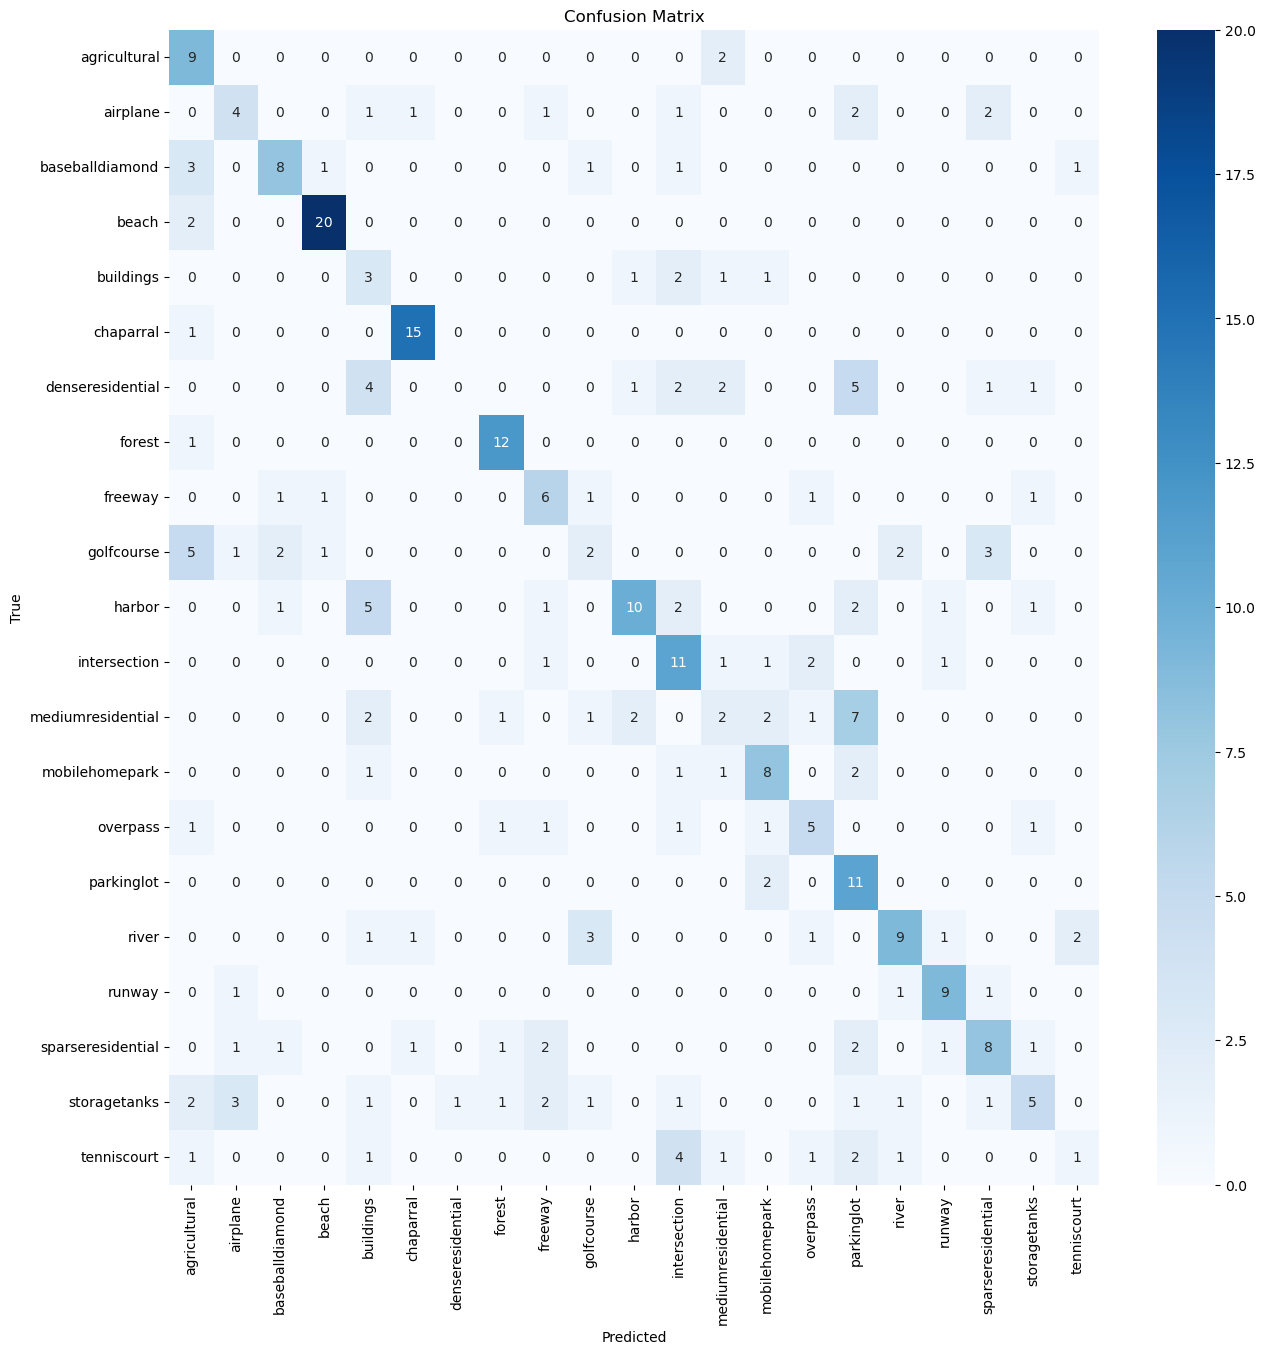

Classification Report:
                   precision    recall  f1-score   support

     agricultural       0.36      0.82      0.50        11
         airplane       0.40      0.33      0.36        12
  baseballdiamond       0.62      0.53      0.57        15
            beach       0.87      0.91      0.89        22
        buildings       0.16      0.38      0.22         8
        chaparral       0.83      0.94      0.88        16
 denseresidential       0.00      0.00      0.00        16
           forest       0.75      0.92      0.83        13
          freeway       0.43      0.55      0.48        11
       golfcourse       0.22      0.12      0.16        16
           harbor       0.71      0.43      0.54        23
     intersection       0.42      0.65      0.51        17
mediumresidential       0.20      0.11      0.14        18
   mobilehomepark       0.53      0.62      0.57        13
         overpass       0.45      0.45      0.45        11
       parkinglot       0.32    

In [33]:
# Evaluate the model on test data
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_accuracy = 100 * test_correct / test_total

print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Confusion Matrix and Classification Report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_predictions)
class_names = CLASSES

plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=class_names))
